# RSNA2024 LSDC Training DenseNet
This notebook is forked [here](https://www.kaggle.com/code/itsuki9180/rsna2024-lsdc-training-baseline). In the [previous notebook](https://www.kaggle.com/code/itsuki9180/rsna2024-lsdc-making-dataset), the author selected the images we wanted to use and exported them to png.The original notebook training. And the original other trained EfficientNet_B4 model with these images. 

I desided to change the model to see if there is any improvement. The reason why I choose DenseNet201 for training is that DenseNet201 has generally same number of parameters and size with EfficientNet_B4 so that I believe that Kaggle GPU could handle it and we don't need extra machine.

### Credit
- [RSNA2024 LSDC Making Dataset](https://www.kaggle.com/code/itsuki9180/rsna2024-lsdc-making-dataset) 
- [RSNA2024 LSDC Training DenseNet](https://www.kaggle.com/code/hugowjd/rsna2024-lsdc-training-densenet) <- you're reading now
- [RSNA2024 LSDC Submission DenseNet](https://www.kaggle.com/code/itsuki9180/rsna2024-lsdc-submission-baseline)

### Reference:
* [Huang, G., Liu, Z., Van Der Maaten, L., and Weinberger, K. Q. Densely connected convolutional networks. CVPR, 2017.](https://arxiv.org/abs/1608.06993)
* [Mingxing Tan and Quoc V. Le. EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. ICML 2019.](https://arxiv.org/abs/1905.11946)

### Future Improvement
* I'm certain that we can run other models to train these images. We can do it by changing ***MODEL_NAME*** parameters in **Config** session. I would list some CNN models which are suitable for image classification and these numbers of parameters.
  * ResNet:
    * ResNet-18: ~11.7 million parameters
    * **ResNet-34: ~21.8 million parameters**
    * **ResNet-50: ~25.6 million parameters**
    * ResNet-101: ~44.5 million parameters
    * ResNet-152: ~60 million parameters
  * VGG:
    * VGG-16: ~138 million parameters
    * VGG-19: ~143 million parameters
  * Inception Networks:
    * Inception v1 (GoogleNet): ~6.8 million parameters
    * Inception v3: ~23.8 million parameters
  * DenseNet:
    * DenseNet-121: ~8 million parameters
    * **DenseNet-169: ~14 million parameters**
    * **DenseNet-201: ~20 million parameters**
    * DenseNet-264: ~33 million parameters
  * MobileNets (parameters can vary significantly with changes in alpha and resolution multipliers):
    * MobileNetV1 (1.0 224): ~4.2 million parameters
    * MobileNetV2 (1.0 224): ~3.5 million parameters
    * MobileNetV3 Large: ~5.4 million parameters
  * Vision Transformers (ViT):
    * ViT-B/16 (base model with patch size 16x16): ~86 million parameters
  * Xception:
    * **Xception: ~22.9 million parameters**
  * EfficientNet
    * EfficientNet-B0: ~5.3 million parameters
    * EfficientNet-B1: ~7.8 million parameters
    * EfficientNet-B2: ~9.2 million parameters
    * EfficientNet-B3: ~12 million parameters
    * **EfficientNet-B4: ~19 million parameters**
    * EfficientNet-B5: ~30 million parameters
    * EfficientNet-B6: ~43 million parameters
    * EfficientNet-B7: ~66 million parameters
* The original author said that we can improve the dataset making process
* I only trained 5 **folds** and 10 **epochs**, you can modify these parameters. But take care of overfitting.

# Import Libralies

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 1.1 MB/s eta 0:00:00m eta 0:00:010:00:010m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [1793 lines of output]
      Partial import of sklearn during the build process.
      setup.py:128: DeprecationWarning:
      
        `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
        of the deprecation of `distutils` itself. It will be removed for
        Python >= 3.12. For older Python versions it will remain present.
        It is recommended to use `setuptools < 60.0` for those Python versions.
        For more details, see:
          https://numpy.org/devdocs/reference/distutils_status_migration.html
      
      
        fro

          2. Declare any exception value explicitly for functions in pxd files.
      performance hint: sklearn/linear_model/_cd_fast.pyx:221:30: Exception check after calling '__pyx_fuse_0_dot' will always require the GIL to be acquired.
      Possible solutions:
          1. Declare '__pyx_fuse_0_dot' as 'noexcept' if you control the definition and you're sure you don't want the function to raise exceptions.
          2. Declare any exception value explicitly for functions in pxd files.
      performance hint: sklearn/linear_model/_cd_fast.pyx:231:31: Exception check after calling '__pyx_fuse_0_asum' will always require the GIL to be acquired.
      Possible solutions:
          1. Declare '__pyx_fuse_0_asum' as 'noexcept' if you control the definition and you're sure you don't want the function to raise exceptions.
          2. Declare any exception value explicitly for functions in pxd files.
      performance hint: sklearn/linear_model/_cd_fast.pyx:235:38: Exception check after ca


[notice] A new release of pip is available: 23.3.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import os
import gc
import sys
from PIL import Image
import cv2
import math, random
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from torchvision.transforms import v2

from collections import OrderedDict
from torch.optim import RAdam
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

import timm
from transformers import get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup

import albumentations as A
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from torch_optimizer import Ranger

/home/anton/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-07-29 14:33:10.630313: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-29 14:33:10.767461: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 14:33:10.767527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 14:33:10.788945: E external/local_xla/xla/stream_exec

In [2]:
rd = 'rsna-2024-lumbar-spine-degenerative-classification'

# Config

In [3]:
# Remember to change NOT_DEBUG to True for real training
NOT_DEBUG = True # True -> run naormally, False -> debug mode, with lesser computing cost

OUTPUT_DIR = f'rsna24-results'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
N_WORKERS = 4
USE_AMP = True # can change True if using T4 or newer than Ampere
SEED = 69

IMG_SIZE = [512, 512]
IN_CHANS = 45
N_LABELS = 25
N_CLASSES = 3 * N_LABELS

AUG_PROB = 0.75
SELECTED_FOLDS = [0, 1, 2, 3, 4]
N_FOLDS = 5 if NOT_DEBUG else 2
EPOCHS = 50 if NOT_DEBUG else 2
# MODEL_NAME = "tf_efficientnet_b4.ns_jft_in1k" if NOT_DEBUG else "tf_efficientnet_b0.ns_jft_in1k"
# TODO: you can choose other convolutional neural network (CNN) architectures designed to 
#       achieve state-of-the-art accuracy in various computer vision tasks

# MODEL_NAME = "vit_base_patch16_siglip_512"
MODEL_NAME = "densenet161"
# MODEL_NAME = 'convnext_small.fb_in22k'
# MODEL_NAME = 'maxvit_tiny_tf_512.in1k'
GRAD_ACC = 2
TGT_BATCH_SIZE = 8
BATCH_SIZE = TGT_BATCH_SIZE // GRAD_ACC
MAX_GRAD_NORM = None
EARLY_STOPPING_EPOCH = 10

LR = 2e-4 * TGT_BATCH_SIZE / 32
WD = 1e-2
AUG = True

cuda:0


In [4]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [5]:
def set_random_seed(seed: int = 2222, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = deterministic  # type: ignore

set_random_seed(SEED)

# Open Dataframes

In [6]:
df = pd.read_csv(f'{rd}/train.csv')
df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


Change the state to Label.

The dataframe contains some Nans, which we will replace with -100 so that We and function can ignore them when calculating the loss and score.

In [7]:
df = df.fillna(-100)

In [8]:
label2id = {'Normal/Mild': 0, 'Moderate':1, 'Severe':2}
df = df.replace(label2id)
df.head()

/tmp/ipykernel_5372/1901592955.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(label2id)


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,4646740,0,0,1,2,0,0,0,0,1,...,0,0,0,2,0,0,1,1,1,0
2,7143189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8785691,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10728036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [9]:
CONDITIONS = [
    'Spinal Canal Stenosis', 
    'Left Neural Foraminal Narrowing', 
    'Right Neural Foraminal Narrowing',
    'Left Subarticular Stenosis',
    'Right Subarticular Stenosis'
]

LEVELS = [
    'L1/L2',
    'L2/L3',
    'L3/L4',
    'L4/L5',
    'L5/S1',
]
model_names = list(df.columns)[1:]
model_names

['spinal_canal_stenosis_l1_l2',
 'spinal_canal_stenosis_l2_l3',
 'spinal_canal_stenosis_l3_l4',
 'spinal_canal_stenosis_l4_l5',
 'spinal_canal_stenosis_l5_s1',
 'left_neural_foraminal_narrowing_l1_l2',
 'left_neural_foraminal_narrowing_l2_l3',
 'left_neural_foraminal_narrowing_l3_l4',
 'left_neural_foraminal_narrowing_l4_l5',
 'left_neural_foraminal_narrowing_l5_s1',
 'right_neural_foraminal_narrowing_l1_l2',
 'right_neural_foraminal_narrowing_l2_l3',
 'right_neural_foraminal_narrowing_l3_l4',
 'right_neural_foraminal_narrowing_l4_l5',
 'right_neural_foraminal_narrowing_l5_s1',
 'left_subarticular_stenosis_l1_l2',
 'left_subarticular_stenosis_l2_l3',
 'left_subarticular_stenosis_l3_l4',
 'left_subarticular_stenosis_l4_l5',
 'left_subarticular_stenosis_l5_s1',
 'right_subarticular_stenosis_l1_l2',
 'right_subarticular_stenosis_l2_l3',
 'right_subarticular_stenosis_l3_l4',
 'right_subarticular_stenosis_l4_l5',
 'right_subarticular_stenosis_l5_s1']

# Define Dataset

This implementation is very slow and leaves a lot of room for improvement.

In [10]:
class RSNA24Dataset(Dataset):
    def __init__(self, df, phase='train', transform=None):
        self.df = df
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = np.zeros((IMG_SIZE[0], IMG_SIZE[1], IN_CHANS), dtype=np.float32)
        t = self.df.iloc[idx]
        st_id = int(t['study_id'])
        label = t[1:].values.astype(np.int64)
        
        # Sagittal T1
        
        sat1 = glob(f'./cvt_png/{st_id}/Sagittal T1/*.png')
        sat1 = sorted(sat1)
    
        step = len(sat1) / (IN_CHANS//3-1)
        st = 0
        end = len(sat1)+0.0001
        
        if len(sat1) != 0:
        
            for i, j in enumerate(np.arange(st, end, step)):
                try:
                    p = sat1[max(0, int((j-0.5001).round()))]
                    img = Image.open(p).convert('L')
                    img = np.array(img)
                    x[..., i] = img.astype(np.float32)
                except:
                    #print(f'failed to load on {st_id}, Sagittal T1')
                    pass
            
        # Sagittal T2/STIR
        sat2 = glob(f'./cvt_png/{st_id}/Sagittal T2_STIR/*.png')
        sat2 = sorted(sat2)
    
        step = len(sat2) / (IN_CHANS//3-1)
        st = 0
        end = len(sat2)+0.0001
        
        if len(sat2) != 0:
            for i, j in enumerate(np.arange(st, end, step)):
                try:
                    p = sat2[max(0, int((j-0.5001).round()))]
                    img = Image.open(p).convert('L')
                    img = np.array(img)
                    x[..., i+IN_CHANS//3] = img.astype(np.float32)
                except:
                    #print(f'failed to load on {st_id}, Sagittal T2/STIR')
                    pass
            
        # Axial T2
        axt2 = glob(f'./cvt_png/{st_id}/Axial T2/*.png')
        axt2 = sorted(axt2)
    
        step = len(axt2) / (IN_CHANS//3-1)
        st = 0
        end = len(axt2)+0.0001
                
        if len(axt2) != 0:
            for i, j in enumerate(np.arange(st, end, step)):
                try:
                    p = axt2[max(0, int((j-0.5001).round()))]
                    img = Image.open(p).convert('L')
                    img = np.array(img)
                    x[..., i+IN_CHANS//3 * 2] = img.astype(np.float32)
                except:
                    #print(f'failed to load on {st_id}, Sagittal T2/STIR')
                    pass  
            
        assert np.sum(x)>0
        if self.transform is not None:
            x = self.transform(image=x)['image']

        x = x.transpose(2, 0, 1)
        
                
        return x, label

# Define Data Augmentaion
Data augmentation is important because the number of images used for training is extremely small.
See [this notebook](https://www.kaggle.com/code/haqishen/1st-place-soluiton-code-small-ver) by [Qishen Ha](https://www.kaggle.com/haqishen) for help setting up this augmentation.

In [11]:
transforms_train = A.Compose([
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=AUG_PROB),

    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=AUG_PROB),

    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=AUG_PROB),
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=0.5, std=0.5)
])

transforms_val = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=0.5, std=0.5)
])

mixup = v2.MixUp(num_classes=N_CLASSES)

if not NOT_DEBUG or not AUG:
    transforms_train = transforms_val

/home/anton/anaconda3/lib/python3.11/site-packages/albumentations/augmentations/blur/transforms.py:189: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


# Trying Data Loader
Checking if the data loader works properly.

x stat: torch.Size([1, 45, 512, 512]) tensor(-1.) tensor(0.9412) tensor(-0.7259) tensor(0.3814)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0]]) torch.Size([1, 25])


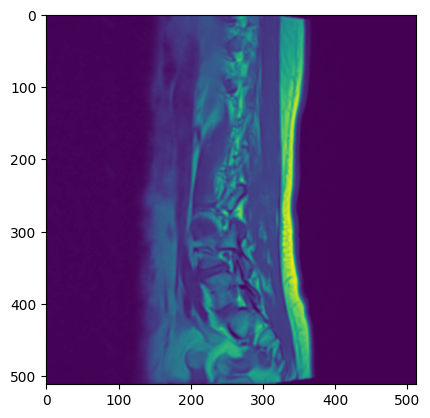

y stat: (512, 512) 0.0 0.91026354 0.11516623 0.1666444

x stat: torch.Size([1, 45, 512, 512]) tensor(-1.) tensor(-0.9922) tensor(-0.9935) tensor(0.0023)
tensor([[0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1,
         0]]) torch.Size([1, 25])


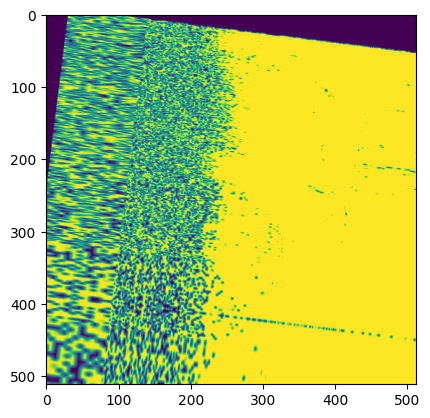

y stat: (512, 512) 0.0 0.0039215386 0.003025444 0.0012546672



In [12]:
tmp_ds = RSNA24Dataset(df, phase='train', transform=transforms_train)
tmp_dl = DataLoader(
            tmp_ds,
            batch_size=1,
            shuffle=False,
            pin_memory=False,
            drop_last=False,
            num_workers=0
            )

for i, (x, t) in enumerate(tmp_dl):
    if i==2:break
    print('x stat:', x.shape, x.min(), x.max(),x.mean(), x.std())
    print(t, t.shape)
    y = x.numpy().transpose(0,2,3,1)[0,...,3]
    y = (y + 1) / 2
    plt.imshow(y)
    plt.show()
    print('y stat:', y.shape, y.min(), y.max(),y.mean(), y.std())
    print()
plt.close()
del tmp_ds, tmp_dl

In [13]:
def one_h(labels):
    result = []
    for label in labels:
        r = []
        for l in label:
            if l == 0:
                r.extend([1.0, 0.0, 0.0])
            elif l == 1:
                r.extend([0.0, 1.0, 0.0])
            else:
                r.extend([0.0, 0.0, 1.0])
                
        result.append(r)
    
    return result

def read_fn(item):
    return {
        'image': item['image'],
        'global_label': item['proba']
    }

# Define Model
We use timm, which is commonly used for image classification.

In [14]:
class RSNA24Model(nn.Module):
    def __init__(self, model_name, in_c=48, n_classes=75, pretrained=True, features_only=False):
        super().__init__()
        self.model = timm.create_model(
                                    model_name,
                                    pretrained=pretrained, 
                                    features_only=features_only,
                                    in_chans=in_c,
                                    num_classes=n_classes,
                                    global_pool='avg'
                                    )
    
    def forward(self, x):
        y = self.model(x)
        return y
    
def get_last_layer(model, x):
    y = model.forward_features(x)
    print(y.shape)

# Testing Model
Checking if the model works properly.

In [15]:
m = RSNA24Model(MODEL_NAME, in_c=IN_CHANS, n_classes=N_CLASSES, pretrained=False)
i = torch.randn(2, IN_CHANS, 512, 512)
out = m(i)
for o in out:
    print(o.shape, o.min(), o.max())

torch.Size([75]) tensor(-0.3753, grad_fn=<MinBackward1>) tensor(0.6852, grad_fn=<MaxBackward1>)
torch.Size([75]) tensor(-0.3530, grad_fn=<MinBackward1>) tensor(0.6671, grad_fn=<MaxBackward1>)


In [16]:
del m, i, out

# Train loop

In [17]:
%time
#autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.bfloat16) # if your gpu is newer Ampere, you can use this, lesser appearance of nan than half
autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half) # you can use with T4 gpu. or newer
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP, init_scale=2048)

val_losses = []
train_losses = []
df_tr, df_test = train_test_split(df, test_size=2/7, random_state=SEED)
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
    loss_scale = 1
    if NOT_DEBUG == False:
        if fold == 1: break;
    if fold not in SELECTED_FOLDS: 
        print(f"Jump fold {fold}")
        continue;
    else:
        print('#'*30)
        print(f'Start fold {fold}')
        print('#'*30)
        print(len(trn_idx), len(val_idx))
        df_train = df.iloc[trn_idx]
        df_valid = df.iloc[val_idx]

        train_ds = RSNA24Dataset(df_train, phase='train', transform=transforms_train)
        train_dl = DataLoader(
                    train_ds,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    pin_memory=False,
                    drop_last=True,
                    num_workers=N_WORKERS
                    )

        valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
        valid_dl = DataLoader(
                    valid_ds,
                    batch_size=BATCH_SIZE*2,
                    shuffle=False,
                    pin_memory=False,
                    drop_last=False,
                    num_workers=N_WORKERS
                    )

        model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=True)
        fname = f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'
#         if os.path.exists(fname):
#             model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=False)
#             model.load_state_dict(torch.load(fname))
        model.to(device)

        optimizer = AdamW(model.parameters(), lr=LR*2, weight_decay=WD)

        warmup_steps = EPOCHS/10 * len(train_dl) // GRAD_ACC
        num_total_steps = EPOCHS * len(train_dl) // GRAD_ACC
        num_cycles = 0.475
        scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=warmup_steps,
                                                    num_training_steps=num_total_steps,
                                                    num_cycles=num_cycles)
#         scheduler = get_linear_schedule_with_warmup(optimizer,
#                                                     num_warmup_steps=warmup_steps,
#                                                     num_training_steps=num_total_steps)

        weights = torch.tensor([1.0, 2.0, 4.0])
        criterion = nn.CrossEntropyLoss(weight=weights.to(device))
        criterion_cpu = nn.CrossEntropyLoss(weight=weights)
        best_loss = 1.2
        es_step = 0

        for epoch in range(1, EPOCHS+1):
            print(f'start epoch {epoch}')
            model.train()
            total_loss = 0
            with tqdm(train_dl, leave=True) as pbar:
                optimizer.zero_grad()
                for idx, (x, t) in enumerate(pbar):  
                    op = ['nothing', 'nothing', 'nothing', 'nothing', 'nothing']
                    x = x.to(device)
                    t = t.to(device)
#                     t = torch.tensor(np.array(one_h(list(t.detach().cpu().numpy())))).to(device)
                    rc = random.sample(op, 1)
                    if rc[0] == 'mixup':
                        x = x.detach().cpu().numpy()
                        t = t.detach().cpu().numpy()
                        reference_data = [{'image':x[i], 'proba': t[i]} 
                                        for i in range(len(x))]
                        tr = A.Compose([A.MixUp(reference_data=reference_data,
                                              read_fn=read_fn, p=0.5)])
                        for i in range(len(x)):
                            transformed = tr(image=x[i], global_label=t[i])
                            x[i] = transformed['image']
                            t[i] = transformed['global_label']
                        
                        x = torch.tensor(x).to(device)
                        t = torch.tensor(t).to(device)
                        
                    with autocast:
                        loss = 0
                        y = model(x)
                        for col in range(N_LABELS):
                            pred = y[:,col*3:col*3+3]
                            gt = t[:,col]
                            loss = loss + loss_scale * criterion(pred, gt) / N_LABELS
                        
                        if not math.isfinite(loss):
                            loss = torch.tensor(1.2 * loss_scale * GRAD_ACC, requires_grad=True)
                        total_loss += loss.item()
                        if GRAD_ACC > 1:
                            loss = loss / GRAD_ACC

                    
                    

                    pbar.set_postfix(
                        OrderedDict(
                            loss=f'{loss.item()*GRAD_ACC:.6f}',
                            lr=f'{optimizer.param_groups[0]["lr"]:.3e}'
                        )
                    )
                    scaler.scale(loss).backward()

                    torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM or 1e9)

                    if (idx + 1) % GRAD_ACC == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()
                        if scheduler is not None:
                            scheduler.step()                    

            train_loss = total_loss/len(train_dl)
            print(f'train_loss:{train_loss/loss_scale:.6f}')
            train_losses.append(train_loss)
            total_loss = 0

            model.eval()
            y_preds, labels = [], []
            with tqdm(valid_dl, leave=True) as pbar:
                with torch.no_grad():
                    for idx, (x, t) in enumerate(pbar):

                        x = x.to(device)
                        t = t.to(device)

                        with autocast:
                            loss = 0
                            loss_ema = 0
                            y = model(x)
                            for col in range(N_LABELS):
                                pred = y[:,col*3:col*3+3]
                                gt = t[:,col]

                                loss = loss + criterion(pred, gt) / N_LABELS
                                y_pred = pred.float()
                                y_preds.append(y_pred.cpu())
                                labels.append(gt.cpu())

                            total_loss += loss.item()   

            val_loss = total_loss/len(valid_dl)
            y_preds = torch.cat(y_preds, dim=0)
            print(y_preds.shape)
            labels = torch.cat(labels)

            val_weighted_loss = criterion_cpu(y_preds, labels)
            print(f'val_loss:{val_loss:.6f}')
            val_losses.append(val_loss)
            if val_weighted_loss < best_loss:

                if device!='cuda:0':
                    model.to('cuda:0')                

                print(f'epoch:{epoch}, best weighted_logloss updated from {best_loss:.6f} to {val_weighted_loss:.6f}')
                best_loss = val_weighted_loss
                fname = f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'
                torch.save(model.state_dict(), fname)
                print(f'{fname} is saved')
                es_step = 0

                if device!='cuda:0':
                    model.to(device)

            else:
                es_step += 1
                if es_step >= EARLY_STOPPING_EPOCH:
                    print('early stopping')
                    break  
                                

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs
##############################
Start fold 0
##############################
1580 395
start epoch 1


100%|████████████| 395/395 [03:50<00:00,  1.71it/s, loss=0.986765, lr=1.996e-05]


train_loss:0.965261


100%|███████████████████████████████████████████| 50/50 [00:33<00:00,  1.49it/s]


torch.Size([9875, 3])
val_loss:0.813684
epoch:1, best weighted_logloss updated from 1.200000 to 0.876051
rsna24-results/best_wll_model_fold-0.pt is saved
start epoch 2


100%|████████████| 395/395 [03:58<00:00,  1.66it/s, loss=0.625040, lr=3.992e-05]


train_loss:0.733970


100%|███████████████████████████████████████████| 50/50 [00:32<00:00,  1.53it/s]


torch.Size([9875, 3])
val_loss:0.720114
epoch:2, best weighted_logloss updated from 0.876051 to 0.788637
rsna24-results/best_wll_model_fold-0.pt is saved
start epoch 3


100%|████████████| 395/395 [03:55<00:00,  1.68it/s, loss=1.162390, lr=5.988e-05]


train_loss:0.703236


100%|███████████████████████████████████████████| 50/50 [00:33<00:00,  1.51it/s]


torch.Size([9875, 3])
val_loss:0.678829
epoch:3, best weighted_logloss updated from 0.788637 to 0.752856
rsna24-results/best_wll_model_fold-0.pt is saved
start epoch 4


100%|████████████| 395/395 [04:03<00:00,  1.62it/s, loss=0.893737, lr=7.984e-05]


train_loss:0.688228


100%|███████████████████████████████████████████| 50/50 [00:32<00:00,  1.53it/s]


torch.Size([9875, 3])
val_loss:0.673053
epoch:4, best weighted_logloss updated from 0.752856 to 0.747651
rsna24-results/best_wll_model_fold-0.pt is saved
start epoch 5


100%|████████████| 395/395 [03:58<00:00,  1.66it/s, loss=0.721547, lr=9.980e-05]


train_loss:0.674297


100%|███████████████████████████████████████████| 50/50 [00:32<00:00,  1.56it/s]


torch.Size([9875, 3])
val_loss:0.664381
epoch:5, best weighted_logloss updated from 0.747651 to 0.740935
rsna24-results/best_wll_model_fold-0.pt is saved
start epoch 6


100%|████████████| 395/395 [03:55<00:00,  1.68it/s, loss=0.699680, lr=9.989e-05]


train_loss:0.658426


100%|███████████████████████████████████████████| 50/50 [00:32<00:00,  1.54it/s]


torch.Size([9875, 3])
val_loss:0.692252
start epoch 7


100%|████████████| 395/395 [03:59<00:00,  1.65it/s, loss=0.682382, lr=9.957e-05]


train_loss:0.658370


100%|███████████████████████████████████████████| 50/50 [00:32<00:00,  1.52it/s]


torch.Size([9875, 3])
val_loss:0.637299
epoch:7, best weighted_logloss updated from 0.740935 to 0.699144
rsna24-results/best_wll_model_fold-0.pt is saved
start epoch 8


100%|████████████| 395/395 [04:00<00:00,  1.65it/s, loss=0.737974, lr=9.903e-05]


train_loss:0.644826


100%|███████████████████████████████████████████| 50/50 [00:33<00:00,  1.51it/s]


torch.Size([9875, 3])
val_loss:0.638542
start epoch 9


100%|████████████| 395/395 [03:59<00:00,  1.65it/s, loss=0.944787, lr=9.827e-05]


train_loss:0.644617


100%|███████████████████████████████████████████| 50/50 [00:32<00:00,  1.52it/s]


torch.Size([9875, 3])
val_loss:0.626493
epoch:9, best weighted_logloss updated from 0.699144 to 0.694962
rsna24-results/best_wll_model_fold-0.pt is saved
start epoch 10


100%|████████████| 395/395 [03:55<00:00,  1.68it/s, loss=0.642423, lr=9.730e-05]


train_loss:0.638486


100%|███████████████████████████████████████████| 50/50 [00:32<00:00,  1.54it/s]


torch.Size([9875, 3])
val_loss:0.622166
epoch:10, best weighted_logloss updated from 0.694962 to 0.687631
rsna24-results/best_wll_model_fold-0.pt is saved
start epoch 11


100%|████████████| 395/395 [03:58<00:00,  1.66it/s, loss=0.829744, lr=9.613e-05]


train_loss:0.630840


100%|███████████████████████████████████████████| 50/50 [00:33<00:00,  1.51it/s]


torch.Size([9875, 3])
val_loss:0.624627
start epoch 12


100%|████████████| 395/395 [04:03<00:00,  1.63it/s, loss=0.465006, lr=9.475e-05]


train_loss:0.618565


100%|███████████████████████████████████████████| 50/50 [00:33<00:00,  1.49it/s]


torch.Size([9875, 3])
val_loss:0.626121
start epoch 13


  4%|▌            | 17/395 [00:12<04:33,  1.38it/s, loss=0.823622, lr=9.469e-05]

KeyboardInterrupt



# Loss Plot

In [ ]:
## Plot Losses during training
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculation CV

In [18]:
for dirname, _, filenames in os.walk(OUTPUT_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

rsna24-results/best_wll_model_fold-0.pt
rsna24-results/models_densenet201.zip
rsna24-results/best_wll_model_fold-2.pt
rsna24-results/labels.npy
rsna24-results/best_wll_model_fold-3.pt
rsna24-results/siska_zhopa.joblib
rsna24-results/best_wll_model_fold-4.pt
rsna24-results/densenet161-5-folds.zip
rsna24-results/densenet161-5-folds-catboost.zip
rsna24-results/best_wll_model_fold-1.pt
rsna24-results/final_oof.npy
rsna24-results/densenet161-lb-0.56-cv-0.61/best_wll_model_fold-0.pt
rsna24-results/densenet161-lb-0.56-cv-0.61/best_wll_model_fold-2.pt
rsna24-results/densenet161-lb-0.56-cv-0.61/best_wll_model_fold-3.pt
rsna24-results/densenet161-lb-0.56-cv-0.61/best_wll_model_fold-4.pt
rsna24-results/densenet161-lb-0.56-cv-0.61/best_wll_model_fold-1.pt
rsna24-results/densenet161-5-folds-catboost-cv-0.6349/best_wll_model_fold-0.pt
rsna24-results/densenet161-5-folds-catboost-cv-0.6349/best_wll_model_fold-2.pt
rsna24-results/densenet161-5-folds-catboost-cv-0.6349/best_wll_model_fold-3.pt
rsna24-re

In [19]:
cv = 0
y_preds = []
labels = []
weights = torch.tensor([1.0, 2.0, 4.0])
criterion2 = nn.CrossEntropyLoss(weight=weights)
autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half) # you can use with T4 gpu. or newer


## TODO: Modify EXIST_FOLDS by how many fold you've trained
EXIST_FOLDS = [0, 1, 2, 3, 4]
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
#     if NOT_DEBUG == False:
#         if fold == 1: break;
    if fold not in EXIST_FOLDS: 
        print(f"Jump fold {fold}")
        continue;
    else:
        print('#'*30)
        print(f'Start fold {fold}')
        print('#'*30)
        df_valid = df.iloc[val_idx]
        valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
        valid_dl = DataLoader(
                    valid_ds,
                    batch_size=16,
                    shuffle=False,
                    pin_memory=False,
                    drop_last=False,
                    num_workers=N_WORKERS
                    )

        model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=False)
        # print("No internet read")
        fname = f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'
        model.load_state_dict(torch.load(fname))
        model.to(device)   

        model.eval()
        with tqdm(valid_dl, leave=True) as pbar:
            with torch.no_grad():
                for idx, (x, t) in enumerate(pbar):

                    x = x.to(device)
                    t = t.to(device)

                    with autocast:
                        y = model(x)
                        for col in range(N_LABELS):
                            pred = y[:,col*3:col*3+3]
                            gt = t[:,col] 
                            y_pred = pred.float()
                            y_preds.append(y_pred.cpu())
                            labels.append(gt.cpu())

y_preds = torch.cat(y_preds)
labels = torch.cat(labels)

##############################
Start fold 0
##############################


100%|███████████████████████████████████████████| 25/25 [00:17<00:00,  1.45it/s]


##############################
Start fold 1
##############################


100%|███████████████████████████████████████████| 25/25 [00:17<00:00,  1.44it/s]


##############################
Start fold 2
##############################


100%|███████████████████████████████████████████| 25/25 [00:17<00:00,  1.44it/s]


##############################
Start fold 3
##############################


100%|███████████████████████████████████████████| 25/25 [00:17<00:00,  1.40it/s]


##############################
Start fold 4
##############################


100%|███████████████████████████████████████████| 25/25 [00:17<00:00,  1.42it/s]


In [20]:
cv = criterion2(y_preds, labels)
print('cv score:', cv.item())

cv score: 0.6323821544647217


# Calculation Competition Metrics
This will give a slightly different score, probably due to the different behavior for nan.

In [ ]:
from sklearn.metrics import log_loss
y_pred_np = y_preds.softmax(1).numpy()
labels_np = labels.numpy()
y_pred_nan = np.zeros((y_preds.shape[0], 1))
y_pred2 = np.concatenate([y_pred_nan, y_pred_np],axis=1)
weights = []
for l in labels:
    if l==0: weights.append(1)
    elif l==1: weights.append(2)
    elif l==2: weights.append(4)
    else: weights.append(0)
cv2 = log_loss(labels, y_pred2, normalize=True, sample_weight=weights)
print('cv score:', cv2)

# CATBOOST TRAINING ON PROBA FROM MODELS 

In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score
models = []

for fold in range(N_FOLDS):
    model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=False)
        # print("No internet read")
    fname = f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'
    model.load_state_dict(torch.load(fname))
    model.to(device)   

    model.eval()
    models.append(model)

cat = CatBoostClassifier(iterations=200, random_seed=SEED)
new_table = pd.DataFrame()
study_ids = []
for row in range(len(df_test)):
    study_id = df_test.iloc[row, 0]
    study_ids.extend([study_id] * 25)
    
new_table['study_id'] = study_ids
new_table['classname'] = [model_name for model_name in model_names] * len(df_test)
predictions = {model_name: {'normal': [], 'moderate':[], 'severe':[]}
               for model_name in model_names}

test_ds = RSNA24Dataset(df_test, phase='valid', transform=transforms_val)
valid_dl = DataLoader(
            test_ds,
            batch_size=BATCH_SIZE*2,
            shuffle=False,
            pin_memory=False,
            drop_last=False,
            num_workers=N_WORKERS
                    )
y_preds, labels = [], []
for model in models:
    labels, y_predss = [], []
    with tqdm(valid_dl, leave=True) as pbar:
        with torch.no_grad():
            for idx, (x, t) in enumerate(pbar):

                x = x.to(device)
                t = t.to(device)

                with autocast:
                    y = model(x)
                    for col in range(N_LABELS):
                        pred = y[:,col*3:col*3+3]
                        gt = t[:,col]
                        y_pred = pred.float()
                        y_predss.append(y_pred.softmax(dim=1).cpu())
                        labels.append(gt.cpu())

            pred_lbs = torch.cat(y_predss, dim=0).argmax(dim=1).detach().cpu().numpy()
            y_predss = torch.cat(y_predss, dim=0).detach().cpu().numpy()
            labels = torch.cat(labels).detach().cpu().numpy()
            print('accuracy_score: ', accuracy_score(pred_lbs, labels))
            y_preds.append(y_predss)

for i in range(len(y_preds)):
    index_model_name = i % 25
    predictions[model_names[index_model_name]]['normal'].append([y_preds[j][i, 0] for j in range(N_FOLDS)])
    predictions[model_names[index_model_name]]['moderate'].append([y_preds[j][i, 1] for j in range(N_FOLDS)])
    predictions[model_names[index_model_name]]['severe'].append([y_preds[j][i, 2] for j in range(N_FOLDS)])
    
for num_model in range(len(models)):
    new_table[f'normal_{num_model}'] = [0 for i in range(len(new_table))]
    new_table[f'moderate_{num_model}'] = [0 for i in range(len(new_table))]
    new_table[f'severe_{num_model}'] = [0 for i in range(len(new_table))]
    
    
new_table['true'] = [0 for i in range(len(new_table))]
weights_train, weights_test = [], []

for row in range(len(new_table)):
    for num_model, model in enumerate(models):
        new_table.iloc[row, 2+num_model*3] = y_preds[num_model][row, 0]
        new_table.iloc[row, 3+num_model*3] = y_preds[num_model][row, 1]
        new_table.iloc[row, 4+num_model*3] = y_preds[num_model][row, 2]
       
    new_table.iloc[row, 5+(len(models)-1)*3] = labels[row]

new_table = new_table.drop(columns=['study_id'])
y = new_table['true']
x = new_table.drop(columns=['true'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, 
                                                   random_state=SEED)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

for i in range(len(y_train)):
    if y_train[i] == 0:
        weights_train.append(1)
    if y_train[i] == 1:
        weights_train.append(2)
    if y_train[i] == 2:
        weights_train.append(4)
    if y_train[i] == -100:
        weights_train.append(0)
        
for i in range(len(y_test)):
    if y_test[i] == 0:
        weights_test.append(1)
    if y_test[i] == 1:
        weights_test.append(2)
    if y_test[i] == 2:
        weights_test.append(4)
    if y_test[i] == -100:
        weights_test.append(0)

original_labels = y_test.copy()

train_data = Pool(data=x_train.to_numpy(),
                 label=y_train,
                 weight=weights_train,
                 cat_features=[0])

test_data = Pool(data=x_test.to_numpy(),
                label=y_test,
                weight=weights_test,
                cat_features=[0])

y_train = [y_train[i] if y_train[i] != -100 else 0 for i in range(len(y_train))]
y_test = [y_test[i] if y_test[i] != -100 else 0 for i in range(len(y_test))]

cat.fit(train_data, eval_set=test_data, use_best_model=True)

In [ ]:
from sklearn.metrics import log_loss
y_pred_np = cat.predict_proba(x_test)
y_pred_np_mean = []
for row in range(len(x_test)):
    res = [0 for i in range(3)]
    res[0]=x_test.iloc[row,1]+x_test.iloc[row,4]+x_test.iloc[row,7]+x_test.iloc[row,10]+x_test.iloc[row,13]
    res[1]=x_test.iloc[row,2]+x_test.iloc[row,5]+x_test.iloc[row,8]+x_test.iloc[row,11]+x_test.iloc[row,14]
    res[2]=x_test.iloc[row,3]+x_test.iloc[row,6]+x_test.iloc[row,9]+x_test.iloc[row,12]+x_test.iloc[row,15]
    y_pred_np_mean.append(res)

y_pred_np_mean = np.array(y_pred_np_mean)

y_pred_nan = np.zeros((y_pred_np.shape[0], 1))
y_pred2 = np.concatenate([y_pred_nan, y_pred_np],axis=1)
y_pred3 = np.concatenate([y_pred_nan, y_pred_np_mean],axis=1)
weights = []
for l in original_labels:
    if l==0: weights.append(1)
    elif l==1: weights.append(2)
    elif l==2: weights.append(4)
    else: weights.append(0)
cv2 = log_loss(original_labels, y_pred_np, normalize=True, sample_weight=weights)
cv3 = log_loss(original_labels, y_pred3, normalize=True, sample_weight=weights)
print('cv score catboost:', cv2)
print('cv score blend:', cv3)

In [ ]:
y_pred3

In [ ]:
from joblib import dump
dump(cat, 'siska_zhopa.joblib')

In [ ]:
# 0 - "-100", 1 - "0", 2 - "1", 3 - "2"

In [ ]:
np.save(f'{OUTPUT_DIR}/labels.npy', labels_np)
np.save(f'{OUTPUT_DIR}/final_oof.npy', y_pred2)

# When predictions are random
gets around 1.1.

In [ ]:
random_pred = np.ones((y_pred_np.shape[0]*2-1, 3)) / 3.0
y_pred3 = np.concatenate([y_pred_nan, random_pred],axis=1)
weights = []
for l in labels:
    if l==0: weights.append(1)
    elif l==1: weights.append(2)
    elif l==2: weights.append(4)
    else: weights.append(0)
cv3 = log_loss(labels, random_pred, normalize=True, sample_weight=weights)
print('random score:', cv3)

# Continuing with the [Submission Baseline...](https://www.kaggle.com/code/itsuki9180/rsna2024-lsdc-submission-baseline)